# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1139]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [1140]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

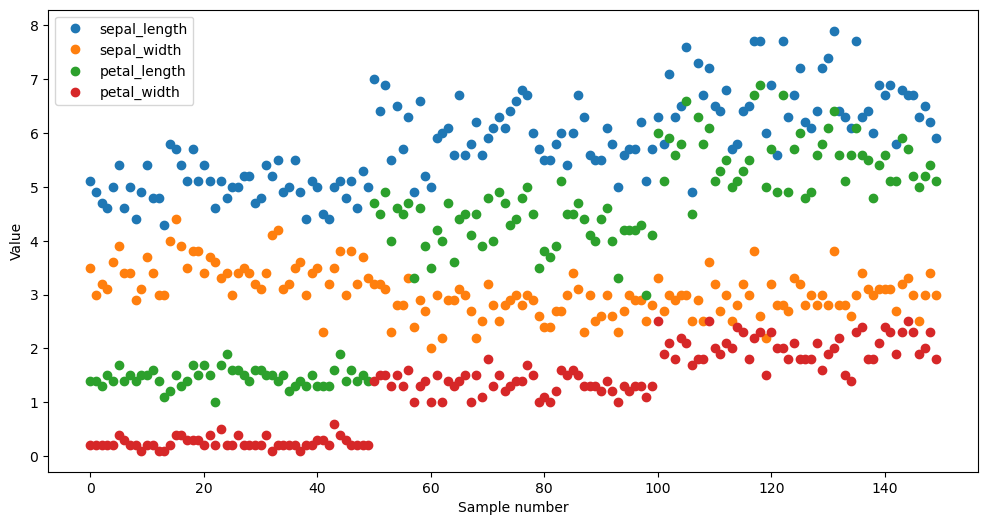

In [1141]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [1142]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [1143]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [1144]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

In [1145]:
def createTrainLoader(batch_size):
    batchsize = batch_size
    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_dataM = TensorDataset(train_data,train_labels)
    test_dataM  = TensorDataset(test_data,test_labels)
    train_loader = DataLoader(train_dataM,batch_size=batchsize,shuffle=True,drop_last=True)
    # finally, translate into dataloader objects
    test_loader  = DataLoader(test_dataM,batch_size=test_dataM.tensors[0].shape[0]) # how big should these batches be??
    return train_loader,test_loader

In [1146]:
# check sizes of data batches
train_loaderX,test_loaderX = createTrainLoader(16)
for X,y in train_loaderX:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


# Construct the model and training plans

In [1147]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.00005)

  return ANNiris,lossfun,optimizer

In [1148]:
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [1149]:
# train the model

# global parameter
numepochs = 500
batch_train_Acc = []
batch_test_Acc = []
batch_loss_Acc = []

def trainTheModel(batch_size):
    
  train_loaderY,test_loaderY = createTrainLoader(batch_size)

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):
    ANNiris.train()
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loaderY:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )  

      # compute training accuracy just for this batch
#       batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
#       batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loaderY)) # extract X,y from test dataloader
    ANNiris.eval()
    with torch.no_grad():
        predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
    
  batch_train_Acc.append(smooth(trainAcc,5))
  batch_test_Acc.append(smooth(testAcc,5))
  batch_loss_Acc.append(smooth(losses,5))
  
  # function output
  #return trainAcc,testAcc,losses


# Test it out

In [1150]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

batchList = [2,4,8,16,32,64]
for batchSize in batchList:
    trainTheModel(batchSize)

# train the model
#trainAcc,testAcc,losses = trainTheModel()


In [1151]:
# print(len(batch_train_Acc))
# print(len(batch_test_Acc))
# print(len(batch_loss_Acc))
# print(len(batch_train_Acc[0]))
# print(len(batch_test_Acc[0]))
# print(len(batch_loss_Acc[0]))
batch_train_Acc = np.array(batch_train_Acc).T
batch_test_Acc = np.array(batch_test_Acc).T
batch_loss_Acc = np.array(batch_loss_Acc).T

In [1152]:
print(batch_train_Acc[:][-5:])
print(batch_test_Acc[:][-5:])
print(batch_loss_Acc[:][-5:])

[[71.33333333 89.16666667 93.33333333 94.10714286 93.95833333 95.        ]
 [71.33333333 89.33333333 93.33333333 94.10714286 93.75       94.375     ]
 [71.16666667 89.5        93.33333333 94.10714286 93.75       94.0625    ]
 [57.         71.66666667 74.66666667 75.17857143 75.20833333 75.        ]
 [42.83333333 53.83333333 56.         56.25       56.04166667 55.9375    ]]
[[56.66666627 83.33333135 86.66666746 89.99999762 93.33333373 93.33333373]
 [57.33333349 83.33333135 86.66666746 89.99999762 93.33333373 93.33333373]
 [58.00000072 83.33333135 86.66666746 89.99999762 93.33333373 93.33333373]
 [46.66666746 66.66666508 69.33333397 71.99999809 74.66666698 74.66666698]
 [35.33333421 49.99999881 52.00000048 53.99999857 56.00000024 56.00000024]]
[[0.49231338 0.38939199 0.3526732  0.33891868 0.33684867 0.32301606]
 [0.49176761 0.3892372  0.35260743 0.33814951 0.336948   0.32732947]
 [0.49120766 0.38909423 0.35253718 0.33753115 0.33406889 0.32893279]
 [0.39274055 0.31121473 0.28200111 0.2721

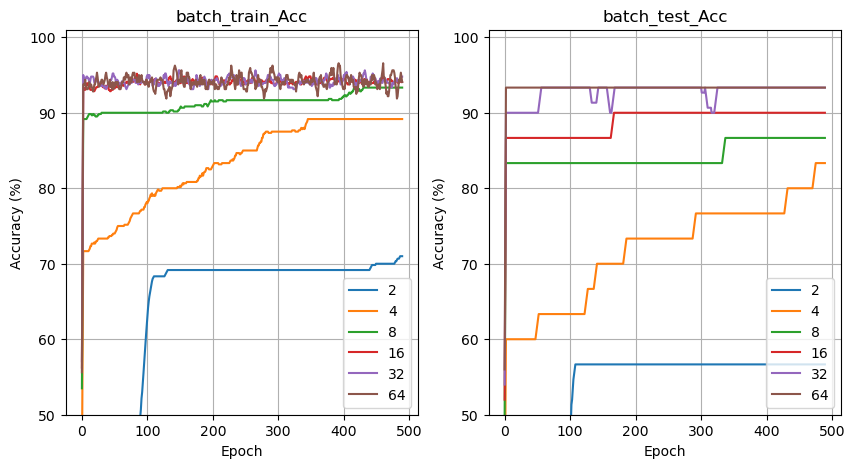

In [1153]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(batch_train_Acc[:-10,:])
ax[1].plot(batch_test_Acc[:-10,:])
#ax[2].plot(batch_loss_Acc)

ax[0].set_title('batch_train_Acc')
ax[1].set_title('batch_test_Acc')
# ax[2].set_title('batch_loss_Acc')

for i in range(2):
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()
  ax[i].legend(batchList)

# ax[2].set_xlabel('Epoch')
# ax[2].set_ylabel('Loss (%)')
# ax[2].set_ylim([0,0.2])

plt.show()

# Additional explorations

In [1154]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects 
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
# MY COMMENTS: test_size = length of test_data/total data ...batch parameter needs to be hardcoded so that we don't 
# end up with large batches when length of test_data is large
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or 
#    "other." What would you have to change in the data and in the model to make this work?
# MY COMMENTS: coded in file DUDL_regular_minibatch-2labels
# 
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the 
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
# MY COMMENTS: yes, 50 VERUS 100